# DNN one-shot replication (PJM)

## DNN one-shot (lookup from published forecasts)

The repo does not ship the DNN weights/training code for a quick one-shot run here. To inspect the published DNN outputs (e.g., DNN 1) for 2016-12-27, we can read them from the benchmark forecasts CSV.


In [2]:
import pandas as pd

# Load published forecasts and show DNN 1 for the target date
forecast_csv = 'forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv'
df_pub = pd.read_csv(forecast_csv)

# Extract first day (2016-12-27) 24-hour DNN 1
print("Published DNN 1 (2016-12-27):")
print(df_pub.loc[:24, 'DNN 1'].to_list())



Published DNN 1 (2016-12-27):
[19.70612335205078, 18.578807830810547, 17.405715942382812, 16.994461059570312, 18.000518798828125, 20.2280216217041, 24.20281219482422, 26.076431274414062, 25.93037223815918, 26.751548767089844, 27.29048156738281, 26.98875617980957, 26.584705352783203, 26.50397682189941, 26.20037651062012, 26.297685623168945, 28.09921264648437, 35.058292388916016, 32.93193817138672, 30.90234375, 28.85091018676757, 26.48240089416504, 24.27153396606445, 22.61918830871582, 22.26004409790039]


## DNN one-shot with hyperparameter search

DNN starts with a pre-selected set of hyperparamters. In this one-shot demo, we first conduct the search and then create DNN prediction.


In [4]:
# Broader hyperparameter search for one-shot DNN (per Lago et al. best-practice: widen space)
# Runtime note: max_evals=50 is a compromise; raise if you want more exploration.

# Searching over 5 iterations is sufficient here with the short training window
import os
from pathlib import Path
from epftoolbox.models import hyperparameter_optimizer

exp_id = 'oneshot_dnn'
data_path = Path('datasets')
work_path = Path('experimental_files')
work_path.mkdir(parents=True, exist_ok=True)

# Relaxed search space knobs
nlayers = 3            # allow up to 3 layers instead of fixing at 2
shuffle_train = 1      # keep shuffling on
data_augmentation = 1  # enable augmentation to explore that dimension
calibration_window = 1 # keep CW consistent with paper baseline
years_test = 5
max_evals = 5         # moderate search budget; increase to 100+ if time permits

trials_file_name = (
    f'DNN_hyperparameters_nl{nlayers}_datPJM_YT{years_test}'
    f"{'_SF' if shuffle_train else ''}"
    f"{'_DA' if data_augmentation else ''}"
    f'_CW{calibration_window}_ME{max_evals}_{exp_id}'
)
trials_path = work_path / trials_file_name

if trials_path.exists():
    print('Trials file already exists, skipping hyperparameter search:')
    print(trials_path)
else:
    print('Running a broader hyperparameter search to create trials file...')
    hyperparameter_optimizer(
        path_datasets_folder=str(data_path),
        path_hyperparameters_folder=str(work_path),
        new_hyperopt=True,
        max_evals=max_evals,
        nlayers=nlayers,
        dataset='PJM',
        years_test=years_test,
        calibration_window=calibration_window,
        shuffle_train=bool(shuffle_train),
        data_augmentation=bool(data_augmentation),
        experiment_id=exp_id,
        begin_test_date=None,
        end_test_date=None,
    )
    print('Saved trials to:', trials_path)


Running a broader hyperparameter search to create trials file...




Tested 1/5 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 14.53 %

Best MAE - Test Dataset
  MAE: 7.8 | sMAPE: 24.11 %




Tested 2/5 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 14.53 %

Best MAE - Test Dataset
  MAE: 7.8 | sMAPE: 24.11 %




Tested 3/5 iterations.
Best MAE - Validation Dataset
  MAE: 3.7 | sMAPE: 11.34 %

Best MAE - Test Dataset
  MAE: 7.1 | sMAPE: 22.57 %




Tested 4/5 iterations.
Best MAE - Validation Dataset
  MAE: 3.0 | sMAPE: 9.13 %

Best MAE - Test Dataset
  MAE: 5.5 | sMAPE: 16.87 %


Saved trials to: experimental_files/DNN_hyperparameters_nl3_datPJM_YT5_SF_DA_CW1_ME5_oneshot_dnn


In [5]:
%%time
# Minimal DNN run for a single test day (2016-12-27)
from epftoolbox.models import evaluate_dnn_in_test_dataset

# Define a single-day test window
begin_test_date = '27/12/2016 00:00'
end_test_date = '27/12/2016 00:00'  # Trick for getting at one day estimate - begin_test_date = end_test_date, where the 24 data points are estimated anyways.

# This will train/recalibrate once and produce a forecast for that day only
import os
os.makedirs('forecasts_local', exist_ok=True)

forecast_dnn = evaluate_dnn_in_test_dataset(
    experiment_id=exp_id,  # must match the hyperopt run above
    path_datasets_folder='datasets',
    path_hyperparameter_folder='experimental_files',
    path_recalibration_folder='forecasts_local',
    dataset='PJM',
    years_test=2,  # ignored when begin/end are provided
    begin_test_date=begin_test_date,
    end_test_date=end_test_date,
    new_recalibration=True,  # force a fresh run instead of loading a prior CSV
)

# Show the 24-hour DNN forecast for 2016-12-27
print("DNN forecast for 2016-12-27 (single-day run):")
print(forecast_dnn.iloc[0].values.tolist())



Test datasets: 2016-12-27 00:00:00 - 2016-12-27 23:00:00


2016-12-27 - sMAPE: 5.06%  |  MAE: 1.272
DNN forecast for 2016-12-27 (single-day run):
[19.449634552001953, 18.56810760498047, 17.62259864807129, 17.147357940673828, 17.58217430114746, 19.477371215820312, 23.781896591186523, 26.33660316467285, 26.208879470825195, 26.380971908569336, 26.03837776184082, 24.918434143066406, 23.752811431884766, 23.38079261779785, 22.87982177734375, 23.20714569091797, 24.48593521118164, 29.28615379333496, 29.39154624938965, 27.19342041015625, 27.029258728027344, 24.766008377075195, 22.42184829711914, 20.777116775512695]
CPU times: user 30.2 s, sys: 2.96 s, total: 33.2 s
Wall time: 30.1 s


In [6]:
forecast_dnn

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-27,19.449635,18.568108,17.622599,17.147358,17.582174,19.477371,23.781897,26.336603,26.208879,26.380972,...,22.879822,23.207146,24.485935,29.286154,29.391546,27.19342,27.029259,24.766008,22.421848,20.777117


In [9]:
# Compare with published benchmark row
published = pd.read_csv('forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv')
published_row = published.loc[:24, 'LEAR 1092'].to_list()

print("Published LEAR 1456:")
print(published_row)



Published LEAR 1456:
[19.106, 18.2766, 17.4325, 17.44, 18.175, 19.8149, 23.511, 25.8432, 26.5383, 27.4225, 28.4752, 28.3429, 27.3322, 26.7224, 25.6884, 25.7518, 27.7477, 36.0018, 32.6576, 31.8707, 31.986, 28.6272, 24.8992, 22.5305, 21.9406]


In [10]:
# Now, print out the columns for the chosen date - 2016-12-27
chosen_date = '2016-12-27'
# Filter the DataFrame to rows matching the chosen date
# Filter to rows for the chosen date
chosen_day_rows = published[published['Unnamed: 0'].str.startswith(chosen_date)]
# Select only the 'D1' to 'D4' columns and transpose them
chosen_day_d1_to_d4_transposed = chosen_day_rows[["DNN 1", "DNN 2", "DNN 3", "DNN 4"]].transpose()
# Print all columns for that day
chosen_day_d1_to_d4_transposed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DNN 1,19.706123,18.578808,17.405716,16.994461,18.000519,20.228022,24.202812,26.076431,25.930372,26.751549,...,26.200377,26.297686,28.099213,35.058292,32.931938,30.902344,28.850910,26.482401,24.271534,22.619188
DNN 2,19.040689,18.628008,17.954073,17.322933,18.452641,20.440174,23.291067,24.964016,25.283371,25.792505,...,24.917231,24.875704,26.216167,32.241158,30.142319,27.851013,27.114426,25.712709,23.455555,21.299164
DNN 3,19.661985,18.581722,17.564003,16.941095,17.457172,19.158525,22.370064,24.356388,25.467987,26.748640,...,25.531353,25.147465,27.194950,33.391148,31.513958,29.097511,28.769260,26.781998,23.786240,22.003754
DNN 4,18.857361,17.804329,16.387474,15.673610,15.920693,18.623030,22.651892,24.700928,24.950792,25.070341,...,23.515644,23.333128,25.200039,31.157816,30.578306,28.333342,28.451826,26.250410,23.073729,21.108505


In [11]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

In [12]:
import pandas as pd

dataLabels = ['rerun', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4', 'actual']
styling_of_plots = ['--', '-', '-', '-', '-', ':']  # Last one distinctly dotted for 'actual'
df = pd.DataFrame([
    forecast_dnn.iloc[0].values.tolist(),
    *chosen_day_d1_to_d4_transposed.values.tolist(),
    actual_value
], index=dataLabels)

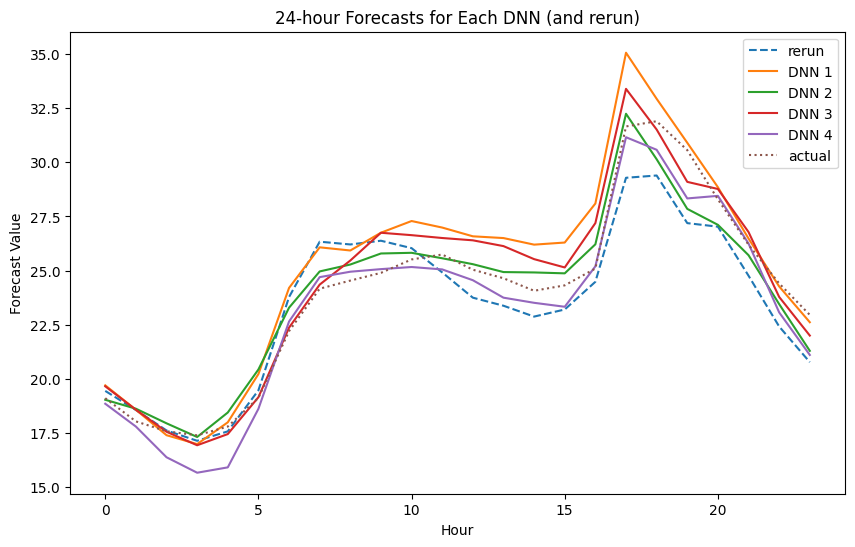

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, (idx, row) in enumerate(df.iterrows()):
    plt.plot(row.values, label=idx, linestyle=styling_of_plots[i])
plt.xlabel("Hour")
plt.ylabel("Forecast Value")
plt.title("24-hour Forecasts for Each DNN (and rerun)")
plt.legend()
plt.show()

In [14]:
forecast_dnn

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-27,19.449635,18.568108,17.622599,17.147358,17.582174,19.477371,23.781897,26.336603,26.208879,26.380972,...,22.879822,23.207146,24.485935,29.286154,29.391546,27.19342,27.029259,24.766008,22.421848,20.777117


In [15]:
forecast_dnn.values

array([[19.449634552001953, 18.56810760498047, 17.62259864807129,
        17.147357940673828, 17.58217430114746, 19.477371215820312,
        23.781896591186523, 26.33660316467285, 26.208879470825195,
        26.380971908569336, 26.03837776184082, 24.918434143066406,
        23.752811431884766, 23.38079261779785, 22.87982177734375,
        23.20714569091797, 24.48593521118164, 29.28615379333496,
        29.39154624938965, 27.19342041015625, 27.029258728027344,
        24.766008377075195, 22.42184829711914, 20.777116775512695]],
      dtype=object)